# Análisis de constantes de filtrado


En esta notebook, haremos un análisis de las constantes para filtrar palabras y usuarios. En el trabajo original utilizamos 40 ocurrencias y 5 usuarios para filtrar, pero puede que no sea el mejor para este nuevo dataset.





In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from contrastes import read_occurrence_dataframe

df = read_occurrence_dataframe("../output/provinces_words.csv")

print("Total de palabras: {}".format(df.shape[0]))

Total de palabras: 2330112


Algunos ejemplos de palabras outsiders...

In [2]:
import hunspell
sc = hunspell.HunSpell("/usr/share/hunspell/es_AR.dic", "/usr/share/hunspell/es_AR.aff")
vocabulary = set()
accum = {}
m = 10

for i in range(1, 40):
    palabras = df[(df.cant_palabra >= (m* (i-1))) & (df.cant_palabra < (m * i))].index 
    cantidad = len(palabras)
    buenas = 0
    
    for w in palabras:
        try:
            if w in vocabulary or sc.spell(w):
                vocabulary.add(w)
                buenas+=1
        except:
            pass
            
    accum[m * i] = (cantidad - buenas) / cantidad


Text(0.5,0,'Cantidad de ocurrencias')

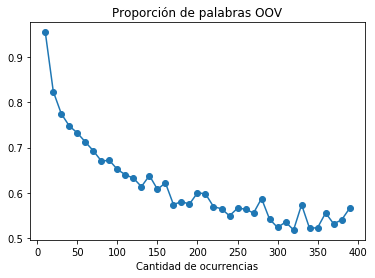

In [3]:
pd.Series(accum).plot(marker="o")

plt.title("Proporción de palabras OOV")
plt.xlabel("Cantidad de ocurrencias")

In [4]:
import hunspell
sc = hunspell.HunSpell("/usr/share/hunspell/es_AR.dic", "/usr/share/hunspell/es_AR.aff")
vocabulary = set()
accum = {}
m = 3

for i in range(1, 28):
    palabras = df[(df.cant_usuarios >= (m* (i-1))) & (df.cant_usuarios < (m * i))].index 
    cantidad = len(palabras)
    buenas = 0
    
    for w in palabras:
        try:
            if w in vocabulary or sc.spell(w):
                vocabulary.add(w)
                buenas+=1
        except:
            pass
            
    accum[m * i] = (cantidad - buenas) / cantidad


Text(0.5,0,'Cantidad de usuarios')

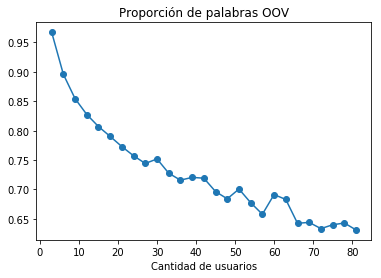

In [5]:
pd.Series(accum).plot(marker="o")

plt.title("Proporción de palabras OOV")
plt.xlabel("Cantidad de usuarios")

# Frecuencia acumulada 

Veamos primero la proporción de palabras del total que tienen menos que $5i$ apariciones

Text(0.5,1,'Proporción acumulada de palabras con menos de X ocurrencias')

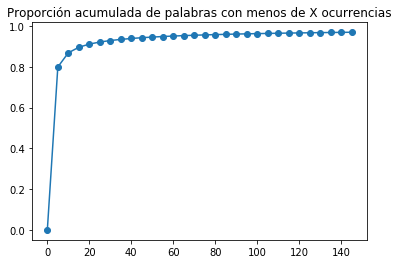

In [6]:
accum = { 0: 0 }

m = 5

for i in range(1, 30):
    accum[m * i] = len(df[df.cant_palabra < (m*i)]) / len(df)
pd.Series(accum).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X ocurrencias")

Viendo esto, como mínimo hay que eliminar las que tienen menos de 20 ocurrencias.

Veamos qué pasa con los usuarios...

Text(0.5,1,'Proporción acumulada de palabras con menos de X usuarios')

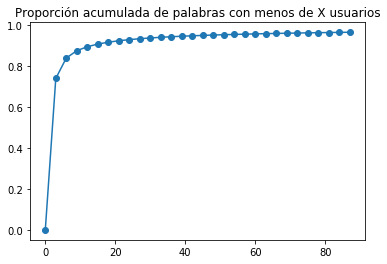

In [7]:
accum = { 0: 0 }

m = 3

for i in range(1, 30):
    accum[m * i] = len(df[df.cant_usuarios < (m*i)]) / len(df)
pd.Series(accum).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X usuarios")

## Usando la masa de ocurrencias

Text(0.5,1,'Proporción acumulada de palabras con menos de X ocurrencias')

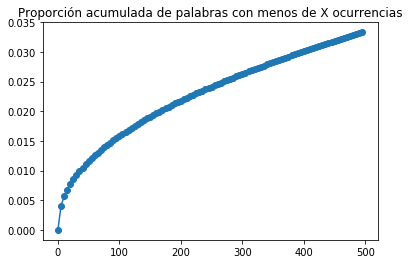

In [8]:


accum_palabras = { 0: 0 }

m = 5
total = df.cant_palabra.sum()

for i in range(1, 100):
    palabras = df[df.cant_palabra < (m*i)]
    accum_palabras[m * i] = palabras.cant_palabra.sum() / total
pd.Series(accum_palabras).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X ocurrencias")

Este gráfico puede echar un poco más de luz. Acá el crecimiento de la masa de ocurrencias se estabiliza alrededor de 100.

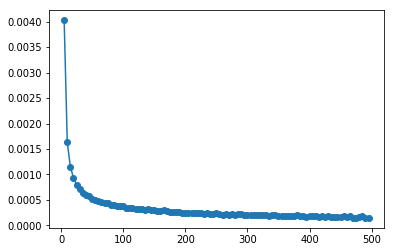

In [18]:
pd.Series(accum_palabras).diff().plot(marker='o')

Si bien es cierto que para N=40 hace que dejemos el 1% de la masa de las palabras, viendo la diferencia de crecimiento ésta parece estabilizarse para N=80. Prefiero quedarme con esto.

Text(0.5,1,'Proporción acumulada de palabras con menos de X ocurrencias')

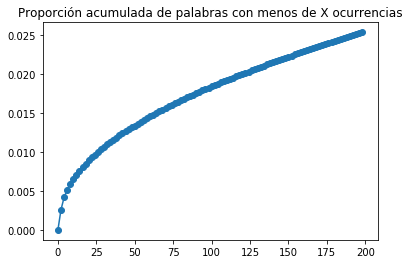

In [19]:


accum_personas = { 0: 0 }

m = 2
total = df.cant_palabra.sum()

for i in range(1, 100):
    palabras = df[df.cant_usuarios < (m*i)]
    accum_personas[m * i] = palabras.cant_palabra.sum() / total
pd.Series(accum_personas).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X ocurrencias")

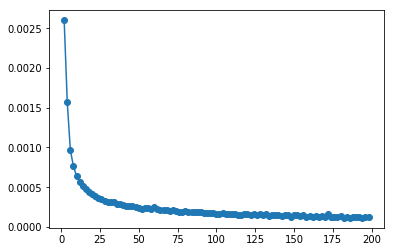

In [20]:
pd.Series(accum_personas).diff().plot(marker='o')

Alrededor de 20 usuarios estabilizan las palabras...

## Conclusión

Viendo que se estabiliza la función de densidad acumulada cerca de 100 palabras y 25 personas, decidimos usar esos parámetros.